In [3]:
## This version of 1D greedy algorithm, the numerical quadrature used for assembling the linear system is consistent with 
## the quadrature used for the argmax subproblem.
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

pi = torch.tensor(np.pi,dtype=torch.float64)
torch.set_default_dtype(torch.float64)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1



In [4]:
def GQ_piecewise(gw,gx,nodes,func): 
    """
    nodes: [x0,x1,...,x_n]^T, column vector, give the subintervals on which we do quadrature
    func: the function to be integrated
    gw: weights of GQ for the interval [-1,1], column vector
    gx: GQ points on the interval [-1,1], row vector
    on each subinterval i: coef1[i] * sum_{j = 1}^5 f(coef1[i] xi_j + coef2[i]) * w_j 
    """
    n = len(nodes) - 1 
    # 1. Get the transformed integration points for each subinterval, stored in rows
    # e.g. 5 point GQ: then each subinterval corresponds to 5 integration points on [-1,1]
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    
    # 2. Function values on the integration points on each subinterval
    func_values = func(integration_points)
    # Modify gw, coef1 to be compatible with func_values
    gw = torch.tile(gw,(n,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    integral_values = func_values*gw*coef1_expand

    #3. Sum up 
    total_integral = torch.sum(integral_values,0)
    return total_integral

def PiecewiseGQ1D(x_l, x_r, target, Nx,order=5): 
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    
    x_r: float
    right endpoint of an interval 
    
    integration_points: tensor
    
    Returns
    -------
    coef1_expand
    
    gw_expand
    
    integration_points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    # nodes = integration_points
    # num_points = len(nodes) - 1  
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    func_values = target(integration_points) 
    long_weights = coef1_expand*gw_expand
    integral_value = long_weights.T@func_values 
    return integral_value

def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    
    x_r: float
    right endpoint of an interval 
    
    integration_intervals: int
    number of subintervals for integration
    
    Returns
    -------
    coef1_expand
    
    gw_expand
    
    integration_points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)


def minimize_linear_layer(model,target,solver="direct",Nx = 1024, order = 5):
    """
    calls the following functions (dependency): 
    1. compute_integration_nodes_relunn
    2. GQ_piecewise
    3. loss_function
    4. rhs_loss
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    def loss_function_inside(x):
        #my_model is a global variable
        return 0.5*torch.pow(model(x)-target(x),2).to(device)

    def rhs_loss_inside(x): 
        # Helper function: differentiate this wrt linear layer parameters give the rhs
        return model(x)*target(x)
     
    # loss = GQ_piecewise(gw,gx,node,loss_function_inside) #loss_function
    loss = PiecewiseGQ1D(-pi,pi,loss_function_inside,Nx,order=order) #loss_function 

    # Extract the linear system A :  
    du1 = torch.autograd.grad(outputs=loss, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    jac = '' # Fix a bug: my_model -> model 2023 Mar. 14th 
    torch.set_printoptions(precision=8)
    neuron_number = model.fc1.bias.size(0)
    for i in range(neuron_number): # Fix a bug: hidden_size1 -> neuron_number 2023 Mar. 14th 
        duui = torch.autograd.grad(outputs=du1[0,i], inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
        if i == 0: # Fix a bug: my_model -> model 2023 Mar. 14th 
            jac = duui
        else: 
            jac = torch.cat([jac,duui],dim=0)
    loss_helper = PiecewiseGQ1D(-pi,pi,rhs_loss_inside,Nx,order=order) 

    rhs = torch.autograd.grad(outputs=loss_helper, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    rhs = rhs.view(-1,1)

    # Solve the linear system using CG
    # print("using: ",solver, end = " ")
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
#         sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    return sol 


def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
#     plt.plot(x_model_pt,u_model_pt,'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()


## OGA

In [4]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degrbuhee of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)


    # relu_dict_parameters[N:,0] = -torch.ones(N)[:]
    # relu_dict_parameters[N:,1] = torch.linspace(x_l,x_r,N+1)[1:] # relu(x-bi)
    
    return relu_dict_parameters


def OGAL2FittingReLU1D(my_model,target,N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= -pi,x_r= pi, Nx = Nx,order =order)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(-pi,pi,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*weights

#         basis_values = F.relu(integration_points - bi).T # uses broadcasting
        basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
        
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 

        neuron_index = torch.argmax(output.flatten())
        
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,weights, integration_points,solver=solver)
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(-pi,pi,200).view(-1,1).to(device)
            u_true = target(x_test)
            plot_solution_modified(-pi,pi,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model



##

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.rand(N)*(x_r-x_l) + x_l # relu(x-bi) 
    # torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)
    
    return relu_dict_parameters
def OGAL2FittingReLU1D_MC(my_model,target,N0,num_epochs,plot_freq = 10,Nx = 1024, order = 3, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= -pi,x_r= pi,Nx = Nx, order = order)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    start_time = time.time()
    
    for i in range(num_epochs): 
        print('epoch ',i + 1 )
        relu_dict_parameters = relu_dict_MC(-pi,pi,N0).to(device)
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*weights

#         basis_values = F.relu(integration_points - bi).T # uses broadcasting
        basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
        
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 

        neuron_index = torch.argmax(output.flatten())
        
#         print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
#         sol = minimize_linear_layer(my_model,target,solver, Nx, order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,weights, integration_points,solver=solver)
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(-pi,pi,200).view(-1,1).to(device)
            u_true = target(x_test)
            plot_solution_modified(-pi,pi,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
    # print("time taken: ",time.time() - start_time)
    return err, my_model

# relu dictionary


## quadratic deterministic

using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.00016498565673828125
solving Ax = b time taken:  0.00018978118896484375
epoch:  2
assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.00013756752014160156
epoch:  3
assembling the matrix time taken:  0.00014162063598632812
solving Ax = b time taken:  0.0001266002655029297
epoch:  4
assembling the matrix time taken:  0.00014328956604003906
solving Ax = b time taken:  0.00012135505676269531
epoch:  5
assembling the matrix time taken:  0.00013971328735351562
solving Ax = b time taken:  0.00012969970703125
epoch:  6
assembling the matrix time taken:  0.00014019012451171875
solving Ax = b time taken:  0.00011968612670898438
epoch:  7
assembling the matrix time taken:  0.0001418590545654297
solving Ax = b time taken:  0.00011873245239257812
epoch:  8
assembling the matrix time taken:  0.00014257431030273438
solving Ax = b time taken:  0.0001373291015625
epoch:  9
assembling the mat

solving Ax = b time taken:  0.0006508827209472656
epoch:  114
assembling the matrix time taken:  0.0001552104949951172
solving Ax = b time taken:  0.0006563663482666016
epoch:  115
assembling the matrix time taken:  0.00015735626220703125
solving Ax = b time taken:  0.0008158683776855469
epoch:  116
assembling the matrix time taken:  0.000156402587890625
solving Ax = b time taken:  0.0008168220520019531
epoch:  117
assembling the matrix time taken:  0.00015544891357421875
solving Ax = b time taken:  0.0008294582366943359
epoch:  118
assembling the matrix time taken:  0.00016117095947265625
solving Ax = b time taken:  0.0008347034454345703
epoch:  119
assembling the matrix time taken:  0.00015544891357421875
solving Ax = b time taken:  0.0008275508880615234
epoch:  120
assembling the matrix time taken:  0.00015664100646972656
solving Ax = b time taken:  0.0007808208465576172
epoch:  121
assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.00079226493835

assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.001279592514038086
epoch:  210
assembling the matrix time taken:  0.00018835067749023438
solving Ax = b time taken:  0.0013048648834228516
epoch:  211
assembling the matrix time taken:  0.0001862049102783203
solving Ax = b time taken:  0.0013113021850585938
epoch:  212
assembling the matrix time taken:  0.0001838207244873047
solving Ax = b time taken:  0.0013072490692138672
epoch:  213
assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.0013301372528076172
epoch:  214
assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.0013175010681152344
epoch:  215
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.0013480186462402344
epoch:  216
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.0013284683227539062
epoch:  217
assembling the matrix time taken:  0.0001742839

solving Ax = b time taken:  0.0020172595977783203
epoch:  281
assembling the matrix time taken:  0.00017952919006347656
solving Ax = b time taken:  0.002022266387939453
epoch:  282
assembling the matrix time taken:  0.00017690658569335938
solving Ax = b time taken:  0.002042531967163086
epoch:  283
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0020449161529541016
epoch:  284
assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.0020394325256347656
epoch:  285
assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.0020554065704345703
epoch:  286
assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.002046346664428711
epoch:  287
assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.0020377635955810547
epoch:  288
assembling the matrix time taken:  0.00017833709716796875
solving Ax = b time taken:  0.002050876617431

epoch:  355
assembling the matrix time taken:  0.0001876354217529297
solving Ax = b time taken:  0.0026445388793945312
epoch:  356
assembling the matrix time taken:  0.00018835067749023438
solving Ax = b time taken:  0.002622365951538086
epoch:  357
assembling the matrix time taken:  0.00017452239990234375
solving Ax = b time taken:  0.002671957015991211
epoch:  358
assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.002673625946044922
epoch:  359
assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.0026581287384033203
epoch:  360
assembling the matrix time taken:  0.0001914501190185547
solving Ax = b time taken:  0.0026504993438720703
epoch:  361
assembling the matrix time taken:  0.00017642974853515625
solving Ax = b time taken:  0.002683877944946289
epoch:  362
assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.0026731491088867188
epoch:  363
assembling the matrix time taken:  0

solving Ax = b time taken:  0.003318309783935547
epoch:  432
assembling the matrix time taken:  0.00017976760864257812
solving Ax = b time taken:  0.0033071041107177734
epoch:  433
assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.003368854522705078
epoch:  434
assembling the matrix time taken:  0.0001964569091796875
solving Ax = b time taken:  0.003343343734741211
epoch:  435
assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.0033767223358154297
epoch:  436
assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.003356456756591797
epoch:  437
assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.003392934799194336
epoch:  438
assembling the matrix time taken:  0.00017976760864257812
solving Ax = b time taken:  0.0033805370330810547
epoch:  439
assembling the matrix time taken:  0.00017905235290527344
solving Ax = b time taken:  0.00339150428771972

epoch:  511
assembling the matrix time taken:  0.0001773834228515625
solving Ax = b time taken:  0.003905057907104492
epoch:  512
assembling the matrix time taken:  0.00016045570373535156
solving Ax = b time taken:  0.003907918930053711


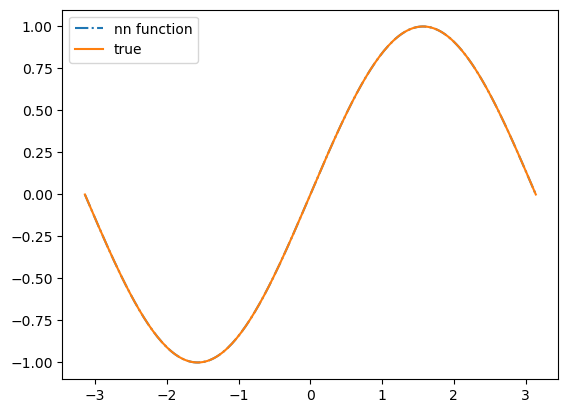

time taken:  4.820188283920288
neuron num 		 error 		 order
4		tensor(0.28037227)		*
8		tensor(0.05889648)		tensor(2.25109040)
16		tensor(0.01242960)		tensor(2.24440179)
32		tensor(0.00300219)		tensor(2.04969090)
64		tensor(0.00076708)		tensor(1.96856749)
128		tensor(0.00018348)		tensor(2.06379053)
256		tensor(4.67135645e-05)		tensor(1.97367341)
512		tensor(1.20649031e-05)		tensor(1.95302521)
using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.00014448165893554688
solving Ax = b time taken:  0.0001437664031982422
epoch:  2
assembling the matrix time taken:  0.00014519691467285156
solving Ax = b time taken:  0.0001277923583984375
epoch:  3
assembling the matrix time taken:  0.00014066696166992188
solving Ax = b time taken:  0.00012493133544921875
epoch:  4
assembling the matrix time taken:  0.00013947486877441406
solving Ax = b time taken:  0.00011658668518066406
epoch:  5
assembling the matrix time taken:  0.0001461505889892578
solving Ax = b time taken:  0.0001

assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.00035881996154785156
epoch:  71
assembling the matrix time taken:  0.00015687942504882812
solving Ax = b time taken:  0.00038242340087890625
epoch:  72
assembling the matrix time taken:  0.00016045570373535156
solving Ax = b time taken:  0.0003800392150878906
epoch:  73
assembling the matrix time taken:  0.00015306472778320312
solving Ax = b time taken:  0.0004017353057861328
epoch:  74
assembling the matrix time taken:  0.000152587890625
solving Ax = b time taken:  0.0004124641418457031
epoch:  75
assembling the matrix time taken:  0.00015234947204589844
solving Ax = b time taken:  0.0004150867462158203
epoch:  76
assembling the matrix time taken:  0.0001609325408935547
solving Ax = b time taken:  0.00040602684020996094
epoch:  77
assembling the matrix time taken:  0.00015282630920410156
solving Ax = b time taken:  0.00041866302490234375
epoch:  78
assembling the matrix time taken:  0.0001552104949

assembling the matrix time taken:  0.00017452239990234375
solving Ax = b time taken:  0.0010623931884765625
epoch:  141
assembling the matrix time taken:  0.00017213821411132812
solving Ax = b time taken:  0.0010993480682373047
epoch:  142
assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.00110626220703125
epoch:  143
assembling the matrix time taken:  0.00017404556274414062
solving Ax = b time taken:  0.0011096000671386719
epoch:  144
assembling the matrix time taken:  0.00017213821411132812
solving Ax = b time taken:  0.0010912418365478516
epoch:  145
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.0011448860168457031
epoch:  146
assembling the matrix time taken:  0.0001723766326904297
solving Ax = b time taken:  0.0011403560638427734
epoch:  147
assembling the matrix time taken:  0.00017213821411132812
solving Ax = b time taken:  0.0011484622955322266
epoch:  148
assembling the matrix time taken:  0.00017142

assembling the matrix time taken:  0.0001862049102783203
solving Ax = b time taken:  0.0013267993927001953
epoch:  222
assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.0013453960418701172
epoch:  223
assembling the matrix time taken:  0.00017142295837402344
solving Ax = b time taken:  0.001367330551147461
epoch:  224
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.001359701156616211
epoch:  225
assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.0014004707336425781
epoch:  226
assembling the matrix time taken:  0.00018405914306640625
solving Ax = b time taken:  0.001394033432006836
epoch:  227
assembling the matrix time taken:  0.0001773834228515625
solving Ax = b time taken:  0.0014128684997558594
epoch:  228
assembling the matrix time taken:  0.00018405914306640625
solving Ax = b time taken:  0.0013892650604248047
epoch:  229
assembling the matrix time taken:  0.000179767

assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.002124309539794922
epoch:  304
assembling the matrix time taken:  0.00017833709716796875
solving Ax = b time taken:  0.002131223678588867
epoch:  305
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.002199888229370117
epoch:  306
assembling the matrix time taken:  0.00019025802612304688
solving Ax = b time taken:  0.002179861068725586
epoch:  307
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.0021970272064208984
epoch:  308
assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.002179384231567383
epoch:  309
assembling the matrix time taken:  0.00019025802612304688
solving Ax = b time taken:  0.0022089481353759766
epoch:  310
assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.0022034645080566406
epoch:  311
assembling the matrix time taken:  0.0001790523

assembling the matrix time taken:  0.00020933151245117188
solving Ax = b time taken:  0.0026428699493408203
epoch:  373
assembling the matrix time taken:  0.0002002716064453125
solving Ax = b time taken:  0.002722024917602539
epoch:  374
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0027604103088378906
epoch:  375
assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.0027565956115722656
epoch:  376
assembling the matrix time taken:  0.0001780986785888672
solving Ax = b time taken:  0.0027518272399902344
epoch:  377
assembling the matrix time taken:  0.00018715858459472656
solving Ax = b time taken:  0.0027801990509033203
epoch:  378
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0027904510498046875
epoch:  379
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.002802610397338867
epoch:  380
assembling the matrix time taken:  0.000187158

solving Ax = b time taken:  0.003591299057006836
epoch:  445
assembling the matrix time taken:  0.0001761913299560547
solving Ax = b time taken:  0.0034279823303222656
epoch:  446
assembling the matrix time taken:  0.00017952919006347656
solving Ax = b time taken:  0.0033957958221435547
epoch:  447
assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.003409862518310547
epoch:  448
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0034089088439941406
epoch:  449
assembling the matrix time taken:  0.00019121170043945312
solving Ax = b time taken:  0.003548145294189453
epoch:  450
assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.003551483154296875
epoch:  451
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.0035419464111328125
epoch:  452
assembling the matrix time taken:  0.00018930435180664062
solving Ax = b time taken:  0.00352406501770019

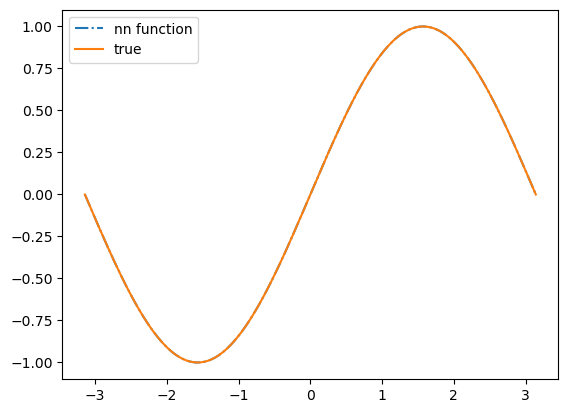

time taken:  6.553848743438721
neuron num 		 error 		 order
4		tensor(0.28188398)		*
8		tensor(0.05899880)		tensor(2.25634394)
16		tensor(0.01236583)		tensor(2.25432631)
32		tensor(0.00299905)		tensor(2.04378040)
64		tensor(0.00075725)		tensor(1.98565855)
128		tensor(0.00018216)		tensor(2.05560231)
256		tensor(4.50101338e-05)		tensor(2.01685248)
512		tensor(1.12402501e-05)		tensor(2.00157571)
using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.00014662742614746094
solving Ax = b time taken:  0.0002181529998779297
epoch:  2
assembling the matrix time taken:  0.00014925003051757812
solving Ax = b time taken:  0.00013065338134765625
epoch:  3
assembling the matrix time taken:  0.0001399517059326172
solving Ax = b time taken:  0.0001881122589111328
epoch:  4
assembling the matrix time taken:  0.000141143798828125
solving Ax = b time taken:  0.00011801719665527344
epoch:  5
assembling the matrix time taken:  0.00013780593872070312
solving Ax = b time taken:  0.000123

epoch:  67
assembling the matrix time taken:  0.00015282630920410156
solving Ax = b time taken:  0.0003833770751953125
epoch:  68
assembling the matrix time taken:  0.00016450881958007812
solving Ax = b time taken:  0.00041365623474121094
epoch:  69
assembling the matrix time taken:  0.000156402587890625
solving Ax = b time taken:  0.00037360191345214844
epoch:  70
assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.0003764629364013672
epoch:  71
assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.0003859996795654297
epoch:  72
assembling the matrix time taken:  0.0001513957977294922
solving Ax = b time taken:  0.0003859996795654297
epoch:  73
assembling the matrix time taken:  0.00015282630920410156
solving Ax = b time taken:  0.00040531158447265625
epoch:  74
assembling the matrix time taken:  0.0001533031463623047
solving Ax = b time taken:  0.0004036426544189453
epoch:  75
assembling the matrix time taken:  0.0

epoch:  136
assembling the matrix time taken:  0.00017118453979492188
solving Ax = b time taken:  0.0010766983032226562
epoch:  137
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.0010869503021240234
epoch:  138
assembling the matrix time taken:  0.00017142295837402344
solving Ax = b time taken:  0.0010902881622314453
epoch:  139
assembling the matrix time taken:  0.00017333030700683594
solving Ax = b time taken:  0.0011107921600341797
epoch:  140
assembling the matrix time taken:  0.000179290771484375
solving Ax = b time taken:  0.0010933876037597656
epoch:  141
assembling the matrix time taken:  0.0001709461212158203
solving Ax = b time taken:  0.0011131763458251953
epoch:  142
assembling the matrix time taken:  0.00017309188842773438
solving Ax = b time taken:  0.0010955333709716797
epoch:  143
assembling the matrix time taken:  0.00017189979553222656
solving Ax = b time taken:  0.0011174678802490234
epoch:  144
assembling the matrix time taken

assembling the matrix time taken:  0.0001857280731201172
solving Ax = b time taken:  0.001245260238647461
epoch:  208
assembling the matrix time taken:  0.00018453598022460938
solving Ax = b time taken:  0.0012714862823486328
epoch:  209
assembling the matrix time taken:  0.0001761913299560547
solving Ax = b time taken:  0.0012903213500976562
epoch:  210
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0013110637664794922
epoch:  211
assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.001312255859375
epoch:  212
assembling the matrix time taken:  0.00018310546875
solving Ax = b time taken:  0.0013079643249511719
epoch:  213
assembling the matrix time taken:  0.0001862049102783203
solving Ax = b time taken:  0.0013251304626464844
epoch:  214
assembling the matrix time taken:  0.00017309188842773438
solving Ax = b time taken:  0.0013327598571777344
epoch:  215
assembling the matrix time taken:  0.0001876354217529297

assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.0019910335540771484
epoch:  278
assembling the matrix time taken:  0.0001976490020751953
solving Ax = b time taken:  0.0020127296447753906
epoch:  279
assembling the matrix time taken:  0.0001773834228515625
solving Ax = b time taken:  0.002032756805419922
epoch:  280
assembling the matrix time taken:  0.0001888275146484375
solving Ax = b time taken:  0.0020089149475097656
epoch:  281
assembling the matrix time taken:  0.00017881393432617188
solving Ax = b time taken:  0.002044677734375
epoch:  282
assembling the matrix time taken:  0.0001914501190185547
solving Ax = b time taken:  0.0020253658294677734
epoch:  283
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.0020346641540527344
epoch:  284
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.0020279884338378906
epoch:  285
assembling the matrix time taken:  0.000196456909179

assembling the matrix time taken:  0.00017762184143066406
solving Ax = b time taken:  0.0025687217712402344
epoch:  348
assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.0025696754455566406
epoch:  349
assembling the matrix time taken:  0.00018835067749023438
solving Ax = b time taken:  0.0025959014892578125
epoch:  350
assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.002588510513305664
epoch:  351
assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.002583026885986328
epoch:  352
assembling the matrix time taken:  0.0001876354217529297
solving Ax = b time taken:  0.0025811195373535156
epoch:  353
assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.0026514530181884766
epoch:  354
assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.0026400089263916016
epoch:  355
assembling the matrix time taken:  0.000187

assembling the matrix time taken:  0.0001971721649169922
solving Ax = b time taken:  0.0032334327697753906
epoch:  419
assembling the matrix time taken:  0.0001914501190185547
solving Ax = b time taken:  0.003246307373046875
epoch:  420
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.0032498836517333984
epoch:  421
assembling the matrix time taken:  0.00019073486328125
solving Ax = b time taken:  0.0032815933227539062
epoch:  422
assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.00327301025390625
epoch:  423
assembling the matrix time taken:  0.00018835067749023438
solving Ax = b time taken:  0.003289937973022461
epoch:  424
assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.0032694339752197266
epoch:  425
assembling the matrix time taken:  0.00018286705017089844
solving Ax = b time taken:  0.003289461135864258
epoch:  426
assembling the matrix time taken:  0.000186204910278

assembling the matrix time taken:  0.000194549560546875
solving Ax = b time taken:  0.0037136077880859375
epoch:  489
assembling the matrix time taken:  0.00016188621520996094
solving Ax = b time taken:  0.0038137435913085938
epoch:  490
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.003807544708251953
epoch:  491
assembling the matrix time taken:  0.00016117095947265625
solving Ax = b time taken:  0.0038242340087890625
epoch:  492
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.003807544708251953
epoch:  493
assembling the matrix time taken:  0.0001621246337890625
solving Ax = b time taken:  0.003835439682006836
epoch:  494
assembling the matrix time taken:  0.0001614093780517578
solving Ax = b time taken:  0.0038347244262695312
epoch:  495
assembling the matrix time taken:  0.00016045570373535156
solving Ax = b time taken:  0.003814697265625
epoch:  496
assembling the matrix time taken:  0.00016307830810

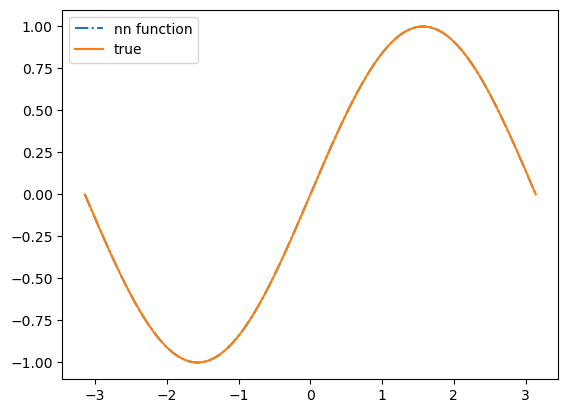

time taken:  13.279277086257935
neuron num 		 error 		 order
4		tensor(0.28166079)		*
8		tensor(0.05897773)		tensor(2.25571645)
16		tensor(0.01237044)		tensor(2.25327377)
32		tensor(0.00300189)		tensor(2.04295452)
64		tensor(0.00077149)		tensor(1.96015368)
128		tensor(0.00018244)		tensor(2.08019288)
256		tensor(4.48811431e-05)		tensor(2.02327039)
512		tensor(1.11949211e-05)		tensor(2.00326506)


In [38]:
# def target(x):
#     return x**2 - pi**2  

def target(x):
    return torch.sin(x)

function_name = "sine1d" 
filename_write = "data/1DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = True  

for N in [2**10, 2**12, 2**14]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**12 
    order = 3   
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, my_model = OGAL2FittingReLU1D(None,target,N,num_epochs,plot_freq, Nx, order, k =1, solver = "ls")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    f_write.write('deterministic dictionary size: {}\n'.format(N))
    f_write.write("neuron num \t\t error \t\t order\n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
            f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    f_write.write("\n")
    f_write.close()
    


## quadratic randomized 

epoch  1
assembling the matrix time taken:  0.00016927719116210938
solving Ax = b time taken:  0.00019598007202148438
epoch  2
assembling the matrix time taken:  0.0001671314239501953
solving Ax = b time taken:  0.0001704692840576172
epoch  3
assembling the matrix time taken:  0.00014901161193847656
solving Ax = b time taken:  0.00017833709716796875
epoch  4
assembling the matrix time taken:  0.00014829635620117188
solving Ax = b time taken:  0.00015974044799804688
epoch  5
assembling the matrix time taken:  0.000148773193359375
solving Ax = b time taken:  0.00015878677368164062
epoch  6
assembling the matrix time taken:  0.00014519691467285156
solving Ax = b time taken:  0.00016689300537109375
epoch  7
assembling the matrix time taken:  0.00014972686767578125
solving Ax = b time taken:  0.00016641616821289062
epoch  8
assembling the matrix time taken:  0.00014472007751464844
solving Ax = b time taken:  0.00019216537475585938
epoch  9
assembling the matrix time taken:  0.00014758110046

assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0015110969543457031
epoch  102
assembling the matrix time taken:  0.00016427040100097656
solving Ax = b time taken:  0.0014405250549316406
epoch  103
assembling the matrix time taken:  0.000164031982421875
solving Ax = b time taken:  0.0013785362243652344
epoch  104
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.0012917518615722656
epoch  105
assembling the matrix time taken:  0.00017547607421875
solving Ax = b time taken:  0.001444101333618164
epoch  106
assembling the matrix time taken:  0.00017452239990234375
solving Ax = b time taken:  0.001314401626586914
epoch  107
assembling the matrix time taken:  0.00016188621520996094
solving Ax = b time taken:  0.0013933181762695312
epoch  108
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.0013399124145507812
epoch  109
assembling the matrix time taken:  0.000161886215209960

assembling the matrix time taken:  0.0001957416534423828
solving Ax = b time taken:  0.0034928321838378906
epoch  180
assembling the matrix time taken:  0.00018095970153808594
solving Ax = b time taken:  0.003409147262573242
epoch  181
assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.003640890121459961
epoch  182
assembling the matrix time taken:  0.00019073486328125
solving Ax = b time taken:  0.0034317970275878906
epoch  183
assembling the matrix time taken:  0.00018310546875
solving Ax = b time taken:  0.0034995079040527344
epoch  184
assembling the matrix time taken:  0.00020265579223632812
solving Ax = b time taken:  0.003336191177368164
epoch  185
assembling the matrix time taken:  0.0001919269561767578
solving Ax = b time taken:  0.0035877227783203125
epoch  186
assembling the matrix time taken:  0.00018024444580078125
solving Ax = b time taken:  0.0035386085510253906
epoch  187
assembling the matrix time taken:  0.00020074844360351562
solv

assembling the matrix time taken:  0.0001800060272216797
solving Ax = b time taken:  0.005975484848022461
epoch  250
assembling the matrix time taken:  0.00019216537475585938
solving Ax = b time taken:  0.005838632583618164
epoch  251
assembling the matrix time taken:  0.00019025802612304688
solving Ax = b time taken:  0.005894184112548828
epoch  252
assembling the matrix time taken:  0.00017952919006347656
solving Ax = b time taken:  0.0060176849365234375
epoch  253
assembling the matrix time taken:  0.00018024444580078125
solving Ax = b time taken:  0.0058553218841552734
epoch  254
assembling the matrix time taken:  0.00018167495727539062
solving Ax = b time taken:  0.00597834587097168
epoch  255
assembling the matrix time taken:  0.0001804828643798828
solving Ax = b time taken:  0.006154298782348633
epoch  256
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.00628209114074707
epoch  257
assembling the matrix time taken:  0.00020360946655273438
s

assembling the matrix time taken:  0.00021123886108398438
solving Ax = b time taken:  0.009284496307373047
epoch  325
assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.009463310241699219
epoch  326
assembling the matrix time taken:  0.00018787384033203125
solving Ax = b time taken:  0.009462118148803711
epoch  327
assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.009603023529052734
epoch  328
assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.009573221206665039
epoch  329
assembling the matrix time taken:  0.00018739700317382812
solving Ax = b time taken:  0.009651660919189453
epoch  330
assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.009824991226196289
epoch  331
assembling the matrix time taken:  0.00018286705017089844
solving Ax = b time taken:  0.009703874588012695
epoch  332
assembling the matrix time taken:  0.00018405914306640625
s

assembling the matrix time taken:  0.00018787384033203125
solving Ax = b time taken:  0.0132598876953125
epoch  400
assembling the matrix time taken:  0.00018715858459472656
solving Ax = b time taken:  0.012576103210449219
epoch  401
assembling the matrix time taken:  0.00019669532775878906
solving Ax = b time taken:  0.014545917510986328
epoch  402
assembling the matrix time taken:  0.0001938343048095703
solving Ax = b time taken:  0.01364588737487793
epoch  403
assembling the matrix time taken:  0.00018668174743652344
solving Ax = b time taken:  0.014402627944946289
epoch  404
assembling the matrix time taken:  0.00018668174743652344
solving Ax = b time taken:  0.013054132461547852
epoch  405
assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.013446569442749023
epoch  406
assembling the matrix time taken:  0.0001888275146484375
solving Ax = b time taken:  0.01381540298461914
epoch  407
assembling the matrix time taken:  0.0001919269561767578
solving

assembling the matrix time taken:  0.00020623207092285156
solving Ax = b time taken:  0.017022371292114258
epoch  475
assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.01744675636291504
epoch  476
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.017548322677612305
epoch  477
assembling the matrix time taken:  0.0002009868621826172
solving Ax = b time taken:  0.017915964126586914
epoch  478
assembling the matrix time taken:  0.00018835067749023438
solving Ax = b time taken:  0.018019914627075195
epoch  479
assembling the matrix time taken:  0.0002028942108154297
solving Ax = b time taken:  0.01793384552001953
epoch  480
assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.018207073211669922
epoch  481
assembling the matrix time taken:  0.00019693374633789062
solving Ax = b time taken:  0.01780414581298828
epoch  482
assembling the matrix time taken:  0.0002002716064453125
solving

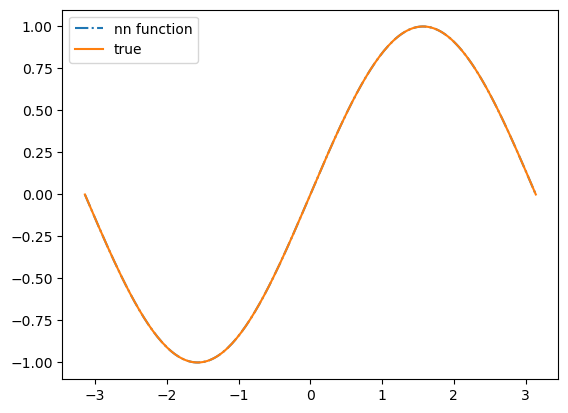

neuron num 		 error 		 order
4		tensor(0.2826)		*
8		tensor(0.0592)		tensor(2.2561)
16		tensor(0.0124)		tensor(2.2486)
32		tensor(0.0031)		tensor(1.9887)
64		tensor(0.0008)		tensor(2.0435)
128		tensor(0.0002)		tensor(1.9803)
256		tensor(4.9192e-05)		tensor(1.9707)
512		tensor(1.4802e-05)		tensor(1.7326)


In [6]:
def target(x):
    return torch.sin(x)

function_name = "sine1d" 
filename_write = "data/1DMCOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = True 

for N in [2**10]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**12 
    order = 3   
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, my_model = OGAL2FittingReLU1D_MC(None,target,N,num_epochs,plot_freq, Nx, order, k =1, solver = "ls")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    f_write.write('randomized dictionary size: {}\n'.format(N))
    f_write.write("neuron num \t\t error \t\t order\n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
            f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    f_write.write("\n")
    f_write.close()
    

using linear solver:  direct
assembling the matrix time taken:  0.0003616809844970703
solving Ax = b time taken:  0.00019288063049316406
assembling the matrix time taken:  0.000354766845703125
solving Ax = b time taken:  0.00020503997802734375
assembling the matrix time taken:  0.0003592967987060547
solving Ax = b time taken:  0.0001919269561767578
assembling the matrix time taken:  0.0003349781036376953
solving Ax = b time taken:  0.00017714500427246094
assembling the matrix time taken:  0.0003368854522705078
solving Ax = b time taken:  0.00016641616821289062
assembling the matrix time taken:  0.00032067298889160156
solving Ax = b time taken:  0.00015974044799804688
assembling the matrix time taken:  0.00031065940856933594
solving Ax = b time taken:  0.000152587890625
assembling the matrix time taken:  0.00031948089599609375
solving Ax = b time taken:  0.00015282630920410156
assembling the matrix time taken:  0.0003235340118408203
solving Ax = b time taken:  0.0001742839813232422
asse

assembling the matrix time taken:  0.00032591819763183594
solving Ax = b time taken:  0.0005414485931396484
assembling the matrix time taken:  0.0003266334533691406
solving Ax = b time taken:  0.0004222393035888672
assembling the matrix time taken:  0.00032591819763183594
solving Ax = b time taken:  0.00043964385986328125
assembling the matrix time taken:  0.0003323554992675781
solving Ax = b time taken:  0.00043010711669921875
assembling the matrix time taken:  0.0003452301025390625
solving Ax = b time taken:  0.00042724609375
assembling the matrix time taken:  0.0003235340118408203
solving Ax = b time taken:  0.00043845176696777344
assembling the matrix time taken:  0.0003285408020019531
solving Ax = b time taken:  0.0004367828369140625
assembling the matrix time taken:  0.00032019615173339844
solving Ax = b time taken:  0.00045371055603027344
assembling the matrix time taken:  0.0003352165222167969
solving Ax = b time taken:  0.00043845176696777344
assembling the matrix time taken: 

assembling the matrix time taken:  0.0003495216369628906
solving Ax = b time taken:  0.0008492469787597656
assembling the matrix time taken:  0.000354766845703125
solving Ax = b time taken:  0.0008513927459716797
assembling the matrix time taken:  0.0003459453582763672
solving Ax = b time taken:  0.0008618831634521484
assembling the matrix time taken:  0.00035834312438964844
solving Ax = b time taken:  0.0008533000946044922
assembling the matrix time taken:  0.0003821849822998047
solving Ax = b time taken:  0.0008246898651123047
assembling the matrix time taken:  0.0003762245178222656
solving Ax = b time taken:  0.0008437633514404297
assembling the matrix time taken:  0.00036215782165527344
solving Ax = b time taken:  0.0008635520935058594
assembling the matrix time taken:  0.0003669261932373047
solving Ax = b time taken:  0.0008544921875
assembling the matrix time taken:  0.0003452301025390625
solving Ax = b time taken:  0.0008709430694580078
assembling the matrix time taken:  0.00036

assembling the matrix time taken:  0.00036716461181640625
solving Ax = b time taken:  0.0013260841369628906
assembling the matrix time taken:  0.0003819465637207031
solving Ax = b time taken:  0.0013704299926757812
assembling the matrix time taken:  0.00036025047302246094
solving Ax = b time taken:  0.0013556480407714844
assembling the matrix time taken:  0.0003669261932373047
solving Ax = b time taken:  0.0013756752014160156
assembling the matrix time taken:  0.00035500526428222656
solving Ax = b time taken:  0.0013871192932128906
assembling the matrix time taken:  0.0003542900085449219
solving Ax = b time taken:  0.0013930797576904297
assembling the matrix time taken:  0.0003542900085449219
solving Ax = b time taken:  0.0013875961303710938
assembling the matrix time taken:  0.0003726482391357422
solving Ax = b time taken:  0.0014030933380126953
assembling the matrix time taken:  0.0003597736358642578
solving Ax = b time taken:  0.0013561248779296875
assembling the matrix time taken: 

assembling the matrix time taken:  0.00038361549377441406
solving Ax = b time taken:  0.0022411346435546875
assembling the matrix time taken:  0.0003838539123535156
solving Ax = b time taken:  0.0023174285888671875
assembling the matrix time taken:  0.0003838539123535156
solving Ax = b time taken:  0.0022735595703125
assembling the matrix time taken:  0.0003609657287597656
solving Ax = b time taken:  0.002335071563720703
assembling the matrix time taken:  0.0003783702850341797
solving Ax = b time taken:  0.0023081302642822266
assembling the matrix time taken:  0.00036525726318359375
solving Ax = b time taken:  0.002337932586669922
assembling the matrix time taken:  0.00038313865661621094
solving Ax = b time taken:  0.0023174285888671875
assembling the matrix time taken:  0.00038695335388183594
solving Ax = b time taken:  0.002332448959350586
assembling the matrix time taken:  0.00036072731018066406
solving Ax = b time taken:  0.002357959747314453
assembling the matrix time taken:  0.00

assembling the matrix time taken:  0.00038552284240722656
solving Ax = b time taken:  0.0030012130737304688
assembling the matrix time taken:  0.0003867149353027344
solving Ax = b time taken:  0.002996206283569336
assembling the matrix time taken:  0.00037932395935058594
solving Ax = b time taken:  0.0030295848846435547
assembling the matrix time taken:  0.0003848075866699219
solving Ax = b time taken:  0.0030219554901123047
assembling the matrix time taken:  0.00039768218994140625
solving Ax = b time taken:  0.003021717071533203
assembling the matrix time taken:  0.0004055500030517578
solving Ax = b time taken:  0.002992391586303711
assembling the matrix time taken:  0.0003979206085205078
solving Ax = b time taken:  0.0030303001403808594
assembling the matrix time taken:  0.00040221214294433594
solving Ax = b time taken:  0.0029964447021484375
assembling the matrix time taken:  0.00037741661071777344
solving Ax = b time taken:  0.0030629634857177734
assembling the matrix time taken:  

assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.0035936832427978516
assembling the matrix time taken:  0.0004000663757324219
solving Ax = b time taken:  0.003601551055908203
assembling the matrix time taken:  0.0003814697265625
solving Ax = b time taken:  0.0035953521728515625
assembling the matrix time taken:  0.0003554821014404297
solving Ax = b time taken:  0.003679513931274414
assembling the matrix time taken:  0.0003619194030761719
solving Ax = b time taken:  0.003663778305053711
assembling the matrix time taken:  0.0003771781921386719
solving Ax = b time taken:  0.003689289093017578
assembling the matrix time taken:  0.0003991127014160156
solving Ax = b time taken:  0.0035779476165771484
assembling the matrix time taken:  0.00035953521728515625
solving Ax = b time taken:  0.0036940574645996094
assembling the matrix time taken:  0.000354766845703125
solving Ax = b time taken:  0.0036809444427490234
assembling the matrix time taken:  0.0003600

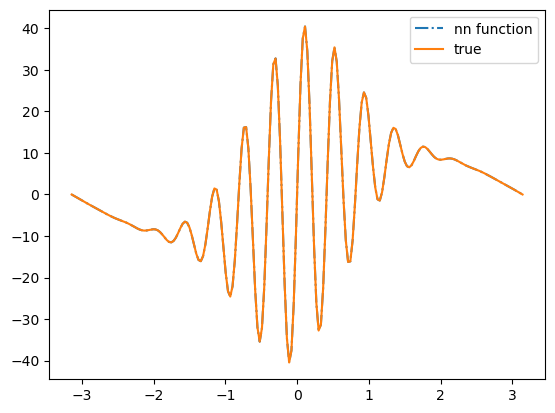

time taken:  13.590233564376831
neuron num 		 error 		 order
4		tensor(31.73892237)		*
8		tensor(29.74876431)		tensor(0.09342340)
16		tensor(11.33224364)		tensor(1.39239622)
32		tensor(4.24459894)		tensor(1.41673338)
64		tensor(1.18477655)		tensor(1.84101325)
128		tensor(0.25589405)		tensor(2.21099649)
256		tensor(0.06466419)		tensor(1.98450771)
512		tensor(0.01645651)		tensor(1.97430901)


In [24]:

def target(x):
    return 10 * torch.sin(x) + 40 * torch.sin(15 * x) * torch.exp(-(x )**2) \
        - 10 * torch.sin(-pi) + 40 * torch.sin(15 * (-pi)) * torch.exp(-(-pi )**2)

function_name = "gabor1d" 
filename_write = "data/1DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 

for N in [2**14]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**12 
    order = 3   
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    

                   
    err_QMC2, my_model = OGAL2FittingReLU1D(None,target,N,num_epochs,plot_freq, Nx, order, k =1, solver = "ls")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    f_write.write('deterministic dictionary size: {}\n'.format(N))
    f_write.write("neuron num \t\t error \t\t order\n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
            f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    f_write.write("\n")
    f_write.close()
    


using linear solver:  direct


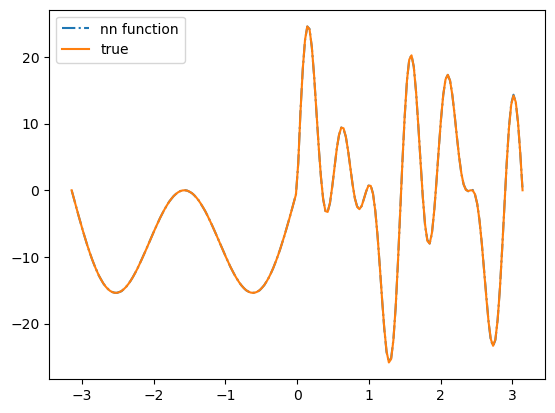

time taken:  9.204200029373169
tensor(26.39361473)
tensor(24.14514390)
tensor(17.26020549)
tensor(8.20040246)
tensor(2.40459449)
tensor(0.46974666)
tensor(0.11673962)


In [5]:
def target(x):
    return 10*(torch.sin(x) + torch.sin(3*x)) + 10*( \
            torch.sin(4*x) + torch.sin(9*x) + torch.sin(13*x)- torch.sin(x) - torch.sin(3*x) \
            )* torch.heaviside(x,torch.tensor([0.0]))

function_name = "Oscillatory"

for N in [2**10]: 
    for num_epochs in [128]: 
        relu_dict_parameters = relu_dict(-pi,pi,N)
        err, my_model = OGAL2FittingReLU1D(None,target,relu_dict_parameters,num_epochs,\
                            plot_freq = num_epochs//1,Nx=1024*1, order = 3, k =1   )
        foldername = 'data-oga/'
        filename = foldername + "err_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(err,filename)

        filename = foldername + "model_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(my_model.state_dict(),filename) 
        for i in [2,4,8,16,32,64,128]:
            print(err[i])


using linear solver:  direct


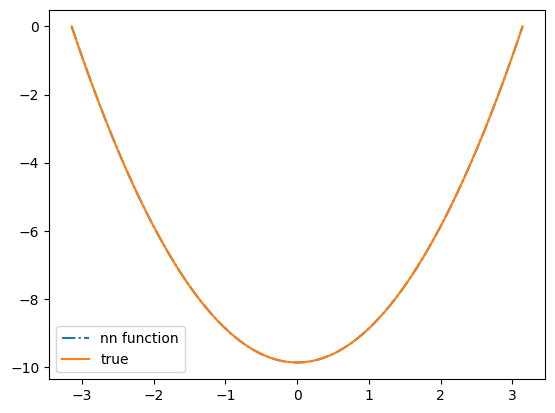

time taken:  9.29564905166626
tensor(2.28844270)
tensor(0.54229041)
tensor(0.13425087)
tensor(0.03326669)
tensor(0.00839900)
tensor(0.00209885)
tensor(0.00053250)


In [5]:
def target(x):
    return x**2 - pi**2  

function_name = "quadratic"

for N in [2**10]: 
    for num_epochs in [128]: 
        relu_dict_parameters = relu_dict(-pi,pi,N)
        err, my_model = OGAL2FittingReLU1D(None,target,relu_dict_parameters,num_epochs,\
                            plot_freq = num_epochs//1,Nx=1024*1, order = 3, k =1   )
        foldername = 'data-oga/'
        filename = foldername + "err_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(err,filename)

        filename = foldername + "model_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(my_model.state_dict(),filename) 
        for i in [2,4,8,16,32,64,128]:
            print(err[i])


In [6]:
for i in [16,32,64,128]:
    print(err[i])

tensor(0.03326669)
tensor(0.00839900)
tensor(0.00209885)
tensor(0.00053250)


In [4]:
function_name = 'quadratic'
N = 1024
num_epochs = 128 
foldername = 'data/'
filename = foldername + "err_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
err =torch.load(filename)
err[64]

FileNotFoundError: [Errno 2] No such file or directory: 'data/err_OGAReLU_quadratic_N_1024_epochs_128.pt'

using linear solver:  direct


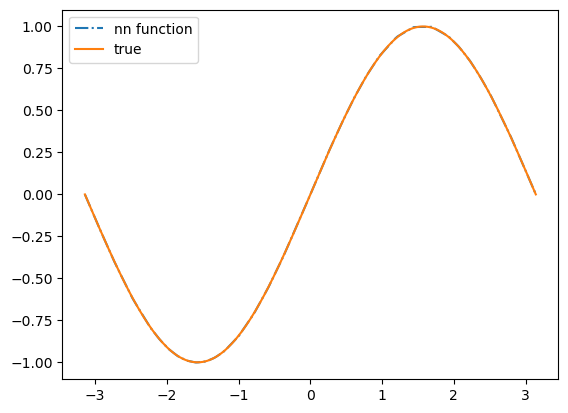

time taken:  0.9617528915405273
using linear solver:  direct


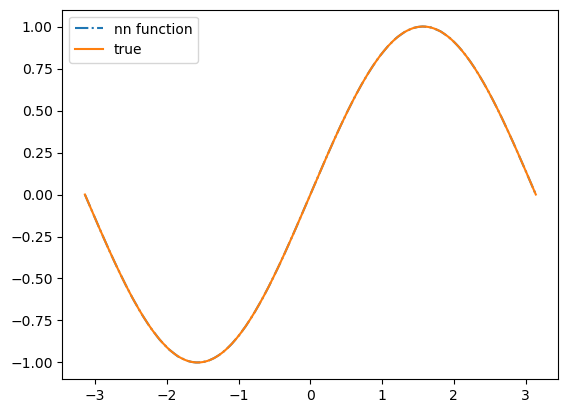

time taken:  2.7889349460601807


In [8]:
def target(x):
    return torch.sin(x)

function_name = "sinx"

for N in [2**10]: 
    for num_epochs in [32,64]: 
        relu_dict_parameters = relu_dict(-pi,pi,N)
        err, my_model = OGAL2FittingReLU1D(None,target,relu_dict_parameters,num_epochs,\
                            plot_freq = num_epochs//1,Nx=1024*1, order = 3, k =1   )
        foldername = 'data-oga/'
        filename = foldername + "err_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(err,filename)

        filename = foldername + "model_OGAReLU_{}_N_{}_epochs_{}.pt".format(function_name, N, num_epochs) 
        torch.save(my_model.state_dict(),filename) 
        # for i in [2,4,8,16,32,64,128]:
        #     print(err[i])